In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 10.0) # Large figures

Populating the interactive namespace from numpy and matplotlib


In [2]:
# gx3v7 output; daily averages
casename='C1850ECO.T62_g37.ciso.marbl_dev_levy'
rundir='/glade2/scratch2/mlevy/%s/run' % casename
date='0001-01-02'
#print '%s/%s.pop.h.%s.nc' % (rundir, casename, casename)
hist=Dataset('%s/%s.pop.h.%s.nc' % (rundir, casename, date), 'r')

In [3]:
import numpy as np

# Dictionaries to store data and metadata
data_to_write = dict()
metadata = dict()

# Pick an (i,j)
# (17,18) is Southern Ocean (28.1 E, 50.576 S); has 56 levels
# (19,50) is near SOFS site SW of Tasmania (143.3 E, 45.695 S); has 54 levels
lat_in = 19
lon_in = 50
print "Longitude:", hist.variables['TLONG'][lat_in,lon_in]
print "Latitude:", hist.variables['TLAT'][lat_in,lon_in]

Longitude: 143.3
Latitude: -45.6946538378


In [4]:
###############
# DOMAIN INFO #
###############

# Note: LHS uses MARBL naming convention, everything converted to mks units
data_to_write['km'] = hist.dimensions['z_t'].size
metadata['km'] = dict()
metadata['km']['longname'] = 'Number of levels'

data_to_write['kw'] = data_to_write['km']+1 # just need a new dimension for zw, which is size km+1
metadata['kw'] = dict()
metadata['kw']['longname'] = 'Number of interfaces'

data_to_write['kmt'] = hist.variables['KMT'][lat_in,lon_in]
metadata['kmt'] = dict()
metadata['kmt']['longname'] = 'Number of active levels'

data_to_write['zt'] = hist.variables['z_t'][:]/100.
metadata['zt'] = dict()
metadata['zt']['longname'] = 'depth from surface to midpoint of layer'
metadata['zt']['units'] = 'm'

data_to_write['zw'] = np.append(hist.variables['z_w'][:]/100.,
                                hist.variables['z_w_bot'][data_to_write['km']-1]/100.)
metadata['zw'] = dict()
metadata['zw']['longname'] = 'depth from surface to top of layer'
metadata['zw']['units'] = 'm'

data_to_write['delta_z'] = hist.variables['dz'][:]/100.
metadata['delta_z'] = dict()
metadata['delta_z']['longname'] = 'thickness of layer'
metadata['delta_z']['units'] = 'm'

for domain_var in ['zt', 'zw']:
    print "minimum %s: %s" % (metadata[domain_var]['longname'], np.min(data_to_write[domain_var]))
    print "maximum %s: %s" % (metadata[domain_var]['longname'], np.max(data_to_write[domain_var]))

for domain_var in ['kmt', 'km']:
    print "%s: %s" % (metadata[domain_var]['longname'], data_to_write[domain_var])


minimum depth from surface to midpoint of layer: 5.0
maximum depth from surface to midpoint of layer: 5374.999817
minimum depth from surface to top of layer: 0.0
maximum depth from surface to top of layer: 5499.990364
Number of active levels: 54
Number of levels: 60


In [5]:
#######################################
# Interior Forcings from history file #
#######################################

data_to_write['dustflux'] = hist.variables['DUST_FLUX'][0,lat_in, lon_in]*10.
metadata['dustflux'] = dict()
metadata['dustflux']['longname'] = 'Dust Flux'
metadata['dustflux']['units'] = '(kg/m^2)/s'

data_to_write['surf_shortwave'] = hist.variables['SHF_QSW'][0,lat_in, lon_in]
metadata['surf_shortwave'] = dict()
metadata['surf_shortwave']['longname'] = 'Solar Short-Wave Heat Flux'
metadata['surf_shortwave']['units'] = 'W/m^2'

data_to_write['potemp'] = hist.variables['TEMP'][0,:,lat_in, lon_in]
metadata['potemp'] = dict()
metadata['potemp']['longname'] = 'Potential Temperature'
metadata['potemp']['units'] = 'degC'

data_to_write['salinity'] = hist.variables['SALT'][0,:,lat_in, lon_in]/1000.
metadata['salinity'] = dict()
metadata['salinity']['longname'] = 'Salinity'
metadata['salinity']['units'] = 'kg/kg'

for surface_forcing in ['dustflux', 'surf_shortwave']:
    print "%s: %s %s" % (metadata[surface_forcing]['longname'],
                         data_to_write[surface_forcing],
                         metadata[surface_forcing]['units'])

Dust Flux: 4.12074033795e-13 (kg/m^2)/s
Solar Short-Wave Heat Flux: 239.414673416 W/m^2


In [6]:
######################################
# Surface Forcings from history file #
######################################

data_to_write['dust_flux'] = data_to_write['dustflux']
metadata['dust_flux'] = dict(metadata['dustflux'])

data_to_write['sst'] = data_to_write['potemp'][0]
metadata['sst'] = dict(metadata['potemp'])
metadata['sst']['longname'] = 'Sea Surface Temperature'

data_to_write['sss'] = data_to_write['salinity'][0]
metadata['sss'] = dict(metadata['salinity'])
metadata['sss']['longname'] = 'Sea Surface Salinity'

for surface_forcing in ['dust_flux', 'sst', 'sss']:
    print "%s: %s %s" % (metadata[surface_forcing]['longname'],
                         data_to_write[surface_forcing],
                         metadata[surface_forcing]['units'])

Dust Flux: 4.12074033795e-13 (kg/m^2)/s
Sea Surface Temperature: 12.5062636761 degC
Sea Surface Salinity: 0.0348654364904 kg/kg


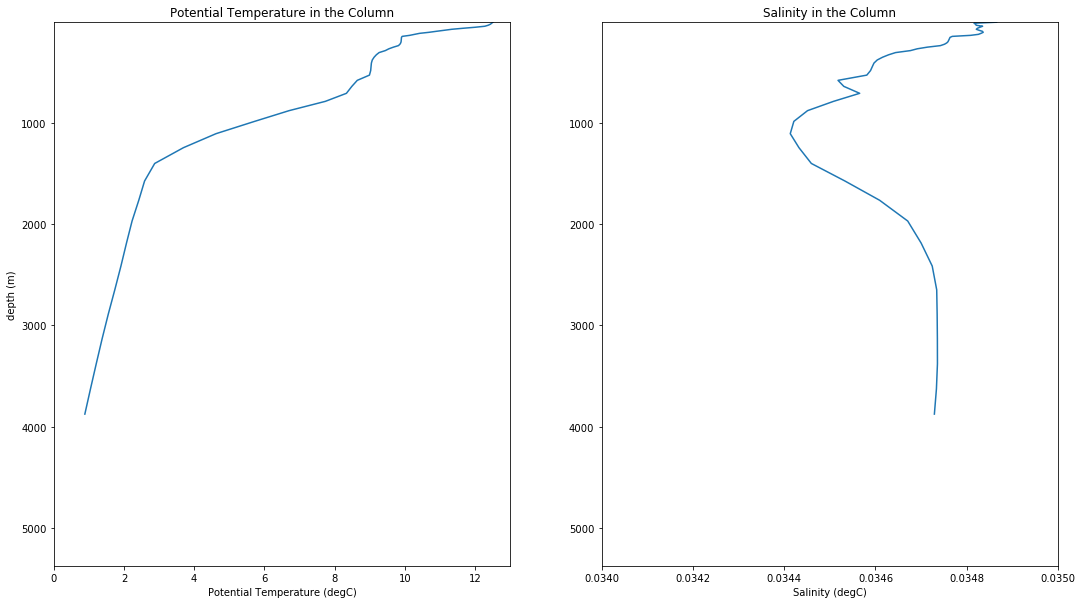

In [7]:
# Plot Potential Temperature
for n, interior_forcing in enumerate(['potemp', 'salinity']):
    plt.subplot(1,2,n+1);
    plt.plot(data_to_write[interior_forcing], data_to_write['zt']);
    plt.title("%s in the Column" % metadata[interior_forcing]['longname']);
    plt.xlabel("%s (%s)" % (metadata[interior_forcing]['longname'], metadata['potemp']['units']));
    plt.ylim(max(data_to_write['zt']), min(data_to_write['zt']));
    if n == 0:
        # Only want y-axis label on left-most plot
        plt.ylabel("depth (m)");
    if interior_forcing == 'potemp':
        plt.xlim(0., 13.);
    if interior_forcing == 'salinity':
        plt.xlim(0.034, 0.035);
